# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
import statsmodels.formula.api as smf
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc, average_precision_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive



In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)

#YOU DEFINED OPENNING GAPS AS TODAY'S OPEN TO YESTERDAY'S CLOSE INSTEAD OF TODAY'S OPEN TO YESTERDAY'S HIGH/LOW..


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()
data['MA_200'] = data['Open'].rolling(window=200).mean()


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_14']).astype(int)


In [6]:
# Logistic regression preparation: Convert 'day_change' to binary and create a new column 'day_change_binary' (0 for Down, 1 for Up)
data['day_change_binary'] = data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

## <a id="section2"></a> Moving Averages: Today's Price Change

In [7]:
# Loop over each moving average period from 1 to 50 days
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = data['Open'].rolling(window=i).mean()

# Calculate the binary variables to check if the opening price is above the moving averages
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = (data['Open'] > data[ma_column]).astype(int)

# Drop rows with NaN values in the newly created columns
columns_of_interest = [f'open_above_MA_{i}' for i in range(1, 51)]
data.dropna(subset=columns_of_interest, inplace=True)


Significant Moving Averages with Coefficients > 0.4:
    Moving Average  Coefficient       P-Value  Odds Ratio  Probability  \
0                2     0.914357  1.306516e-28    2.495170     0.713891   
1                3     0.783759  1.501753e-21    2.189687     0.686490   
2                4     0.737372  3.168717e-19    2.090435     0.676421   
3                5     0.681289  1.279870e-16    1.976424     0.664026   
4                6     0.639606  8.002875e-15    1.895734     0.654664   
5                7     0.592777  7.415684e-13    1.809006     0.644002   
6                8     0.524033  2.204753e-10    1.688825     0.628090   
8               10     0.493813  2.709581e-09    1.638552     0.621004   
7                9     0.477810  7.790575e-09    1.612538     0.617231   
9               11     0.467724  2.024844e-08    1.596358     0.614845   
10              12     0.463393  2.948047e-08    1.589457     0.613819   
11              13     0.445060  1.075604e-07    1.560584 

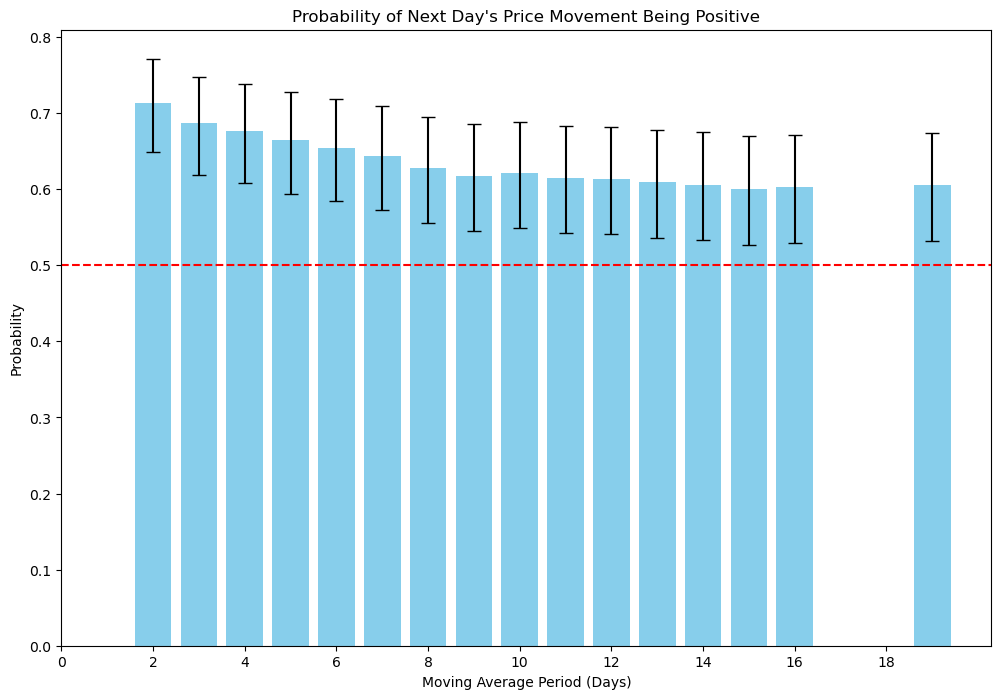


The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.

 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.



In [8]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.copy()

# Drop rows with NaN values in the 'day_change_binary' column and moving average columns
columns_of_interest = ['day_change_binary'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change_binary']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        # Fit the logistic regression model using robust standard errors
        model = sm.Logit(y, X)
        result = model.fit(disp=0, cov_type='HC3')  # Use 'HC3' for robust standard errors
        
        # Extract coefficient and p-value with robust standard errors
        coef = result.params[ma_column]
        p_value = result.pvalues[ma_column]
        
        # Only collect significant results with beta > 0.4
        if p_value < 0.05 and coef > 0.4:
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            # Collect the results
            results_list.append({
                'Moving Average': i,
                'Coefficient': coef,
                'P-Value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob
            })

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for odds ratios and probabilities
results_summary['Odds Ratio Lower Bound'] = np.exp(results_summary['Coefficient'] - 1.96 * results_summary['Coefficient'].std())
results_summary['Odds Ratio Upper Bound'] = np.exp(results_summary['Coefficient'] + 1.96 * results_summary['Coefficient'].std())
results_summary['Probability Lower Bound'] = results_summary['Odds Ratio Lower Bound'] / (1 + results_summary['Odds Ratio Lower Bound'])
results_summary['Probability Upper Bound'] = results_summary['Odds Ratio Upper Bound'] / (1 + results_summary['Odds Ratio Upper Bound'])

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the results
print("\nSignificant Moving Averages with Coefficients > 0.4:")
print(results_summary_sorted)

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted['Moving Average'], results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title('Probability of Next Day\'s Price Movement Being Positive')
plt.xticks(ticks=np.arange(0, 20, 2), labels=np.arange(0, 20, 2))
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.
''')

print(''' 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')



In [9]:
ma_column = 'open_above_MA_2'  # Example predictor

# Add a constant term and log transformation of the predictor
clean_data = clean_data.assign(
    const=1,
    **{f'log_{ma_column}': np.log(clean_data[ma_column] + 1e-10)}
)

# Create interaction term
clean_data[f'interaction_{ma_column}'] = clean_data[ma_column] * clean_data[f'log_{ma_column}']

# Fit the logistic regression model with the interaction term
X = clean_data[['const', ma_column, f'interaction_{ma_column}']]
y = clean_data['day_change_binary']
model = sm.Logit(y, X).fit(disp=0)

print('''
Box-Tillman Test
Given that the interaction term is not significant, you can conclude that there isn't strong evidence of non-linearity in the logit for open_above_MA_2. 
Therefore, you can proceed with the simpler model using only the original predictor.
''')

# Print the summary to check the significance of the interaction term
print(model.summary())





Box-Tillman Test
Given that the interaction term is not significant, you can conclude that there isn't strong evidence of non-linearity in the logit for open_above_MA_2. 
Therefore, you can proceed with the simpler model using only the original predictor.

                           Logit Regression Results                           
Dep. Variable:      day_change_binary   No. Observations:                 2516
Model:                          Logit   Df Residuals:                     2514
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.03635
Time:                        16:57:01   Log-Likelihood:                -1671.9
converged:                       True   LL-Null:                       -1735.0
Covariance Type:            nonrobust   LLR p-value:                 2.856e-29
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------

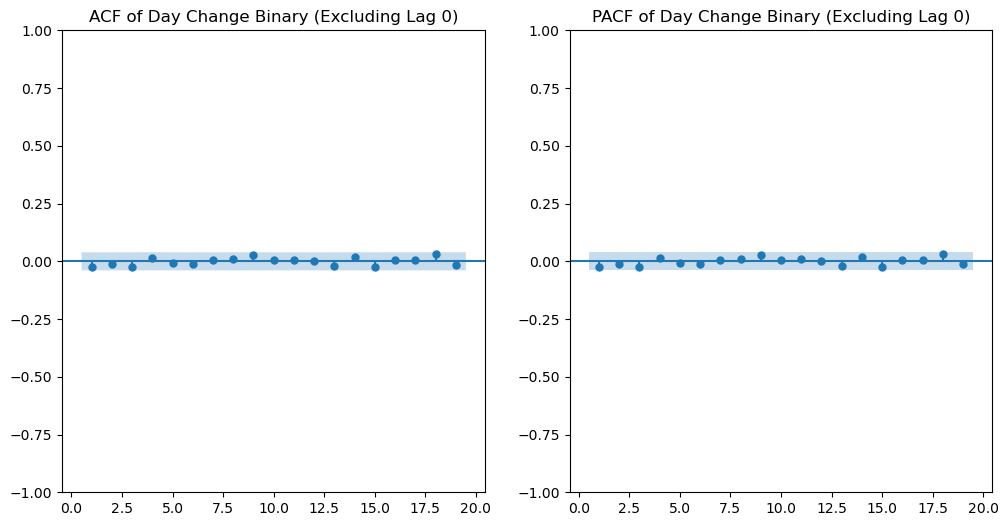

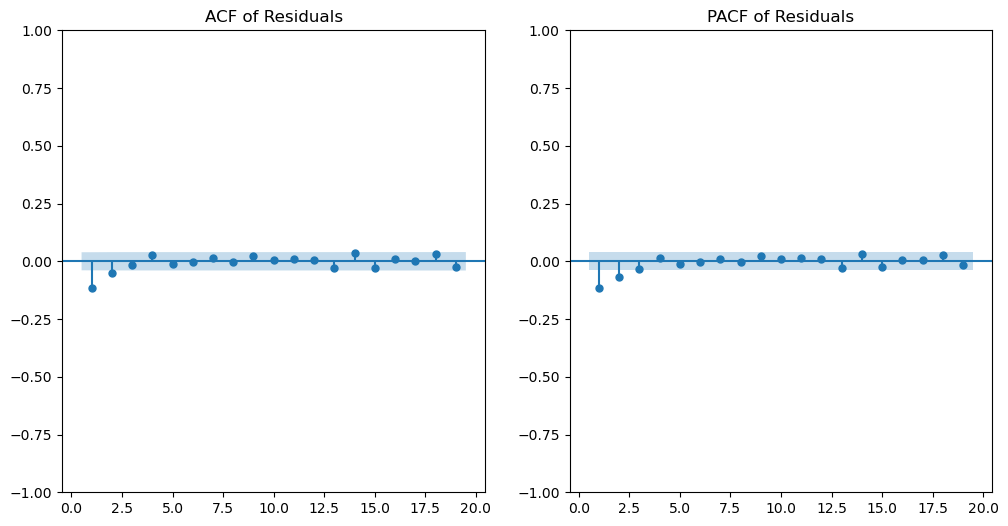

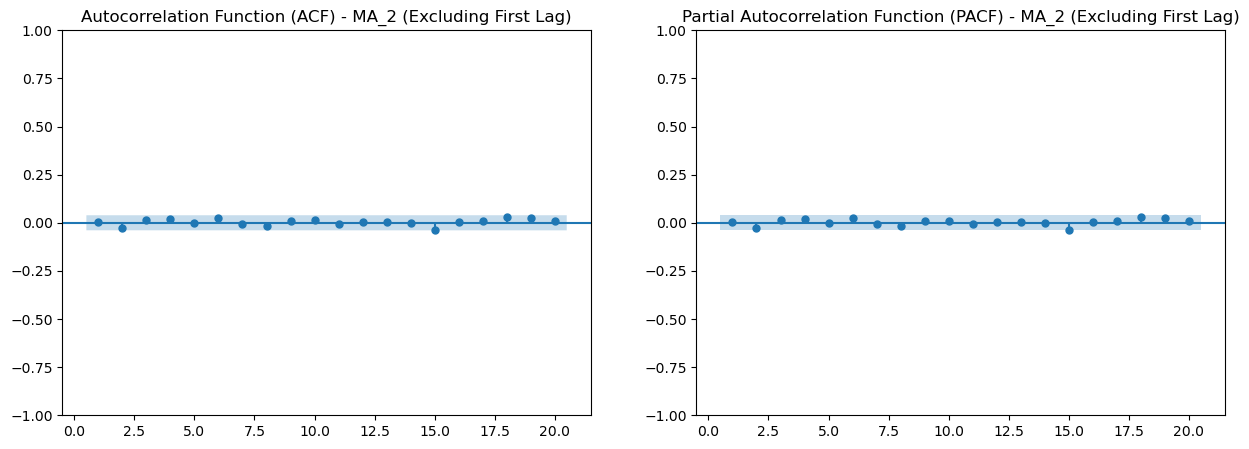


The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

The below charts show that there are no significant temporal dependencies for the dependent variable with itself.
A slow, gradual decline in ACF values suggests a trend in the data and is problematic. 
Values outside the shaded area, which represents two standard deviations, are problematic.


the presence of autocorrelation in residuals can indeed be problematic, as it indicates that the residuals are not independent, which violates one of the key assumptions of 
logistic regression. This can affect the validity of the model's statistical inferences.
This shows that the model is  better modeled as an AR or ARIMA.


Expected Behavior: Autocorrelation at lag 1 (and possibly further lags) is expected and normal for moving averages. This autocorrelation does not necessarily
indicate a prob

In [10]:
# Plot ACF and PACF for the 'day_change_binary' variable excluding lag 0
plt.figure(figsize=(12, 6))

# ACF plot excluding lag 0
plt.subplot(121)
plot_acf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('ACF of Day Change Binary (Excluding Lag 0)')

# PACF plot excluding lag 0
plt.subplot(122)
plot_pacf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('PACF of Day Change Binary (Excluding Lag 0)')

plt.show()


# Example using one predictor for demonstration (you can loop over multiple predictors similarly)
ma_column = 'open_above_MA_3'  # Example predictor

# Fit the logistic regression model using only the predictor
X = sm.add_constant(clean_data[[ma_column]])
y = clean_data['day_change_binary']
model = sm.Logit(y, X).fit(disp=0)

# Calculate residuals
clean_data['residuals'] = y - model.predict(X)

# Plot ACF and PACF for the residuals
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(clean_data['residuals'], lags=19, zero= False, ax=plt.gca())
plt.title('ACF of Residuals')

# PACF plot
plt.subplot(122)
plot_pacf(clean_data['residuals'], lags=19, zero=False, ax=plt.gca())
plt.title('PACF of Residuals')

plt.show()


ma_2 = data['open_above_MA_2']
# Plot ACF and PACF excluding the first lag
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ma_2, ax=axes[0], lags=[i for i in range(1, 21)])
axes[0].set_title('Autocorrelation Function (ACF) - MA_2 (Excluding First Lag)')
plot_pacf(ma_2, ax=axes[1], lags=[i for i in range(1, 21)])
axes[1].set_title('Partial Autocorrelation Function (PACF) - MA_2 (Excluding First Lag)')
plt.show()




print('''
The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

The below charts show that there are no significant temporal dependencies for the dependent variable with itself.
A slow, gradual decline in ACF values suggests a trend in the data and is problematic. 
Values outside the shaded area, which represents two standard deviations, are problematic.
''')

print('''
the presence of autocorrelation in residuals can indeed be problematic, as it indicates that the residuals are not independent, which violates one of the key assumptions of 
logistic regression. This can affect the validity of the model's statistical inferences.
This shows that the model is  better modeled as an AR or ARIMA.
''')



print('''
Expected Behavior: Autocorrelation at lag 1 (and possibly further lags) is expected and normal for moving averages. This autocorrelation does not necessarily
indicate a problem with your model, but rather reflects the characteristics of the moving average calculation.

Model Interpretation: When analyzing models that use moving averages as predictors, it's important to consider this expected autocorrelation. It might not undermine 
the model's validity, but you should be aware of it when interpreting the results.

Model Validity: As long as the residuals behave like white noise beyond these initial lags, your model can still be valid. The initial autocorrelation due to the 
moving average should not undermine the overall model fit.

Additional Diagnostics: Continue to check other diagnostic measures like residual plots, goodness-of-fit statistics, and potential multicollinearity to ensure the
model is robust.

''')


Confusion Matrix:
[[650 502]
 [466 898]]


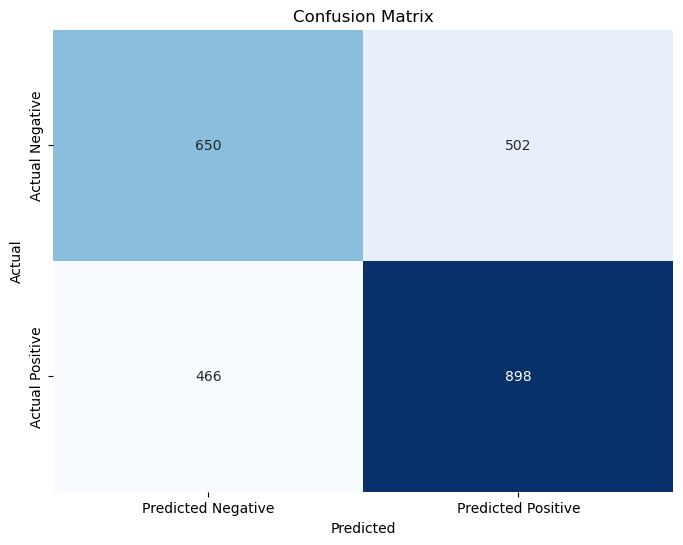

In [11]:
# Fit a logistic regression model for a specific moving average, e.g., MA_2
ma_column = 'open_above_MA_2'
X = clean_data[[ma_column]]
y = clean_data['day_change_binary']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit(disp=0)  # disp=0 suppresses the output

# Predict the probabilities and classify the outcome
y_pred_prob = result.predict(X)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


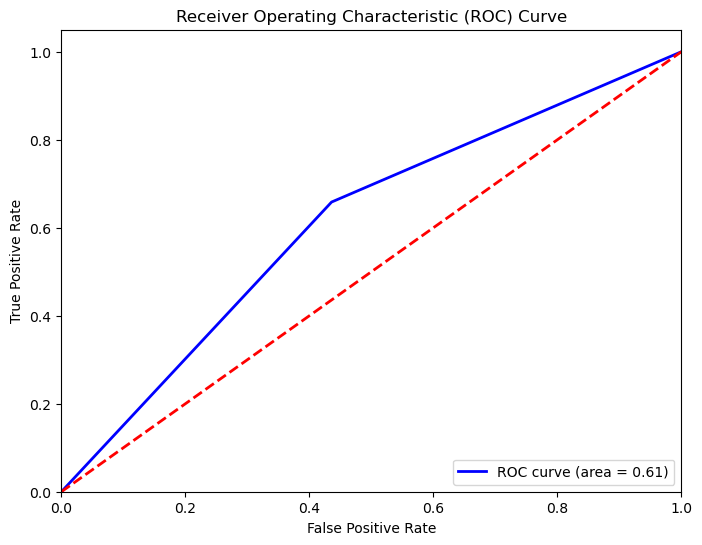

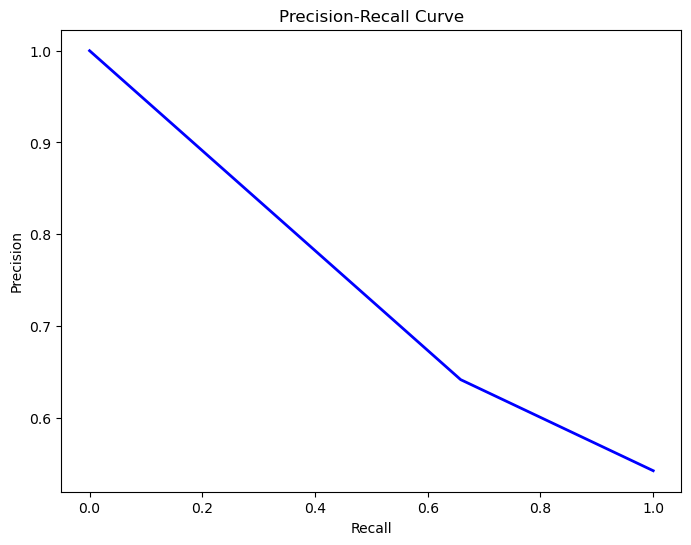


By examining the ROC curve, choose the threshold that best balances sensitivity (catching all positives) and specificity (avoiding false positives)
based on the context and cost of misclassification in your specific application.



In [12]:
# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



print('''
By examining the ROC curve, choose the threshold that best balances sensitivity (catching all positives) and specificity (avoiding false positives)
based on the context and cost of misclassification in your specific application.
''')

In [13]:
# Clean data and drop rows with NaN values in the columns of interest
clean_data = data.copy()
columns_of_interest = ['day_change_binary'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Reference the Original_Index column for groups
group_id = clean_data['Original_Index']

# Specify the response variable and the predictor
y = clean_data['day_change_binary']
X = clean_data[[f'open_above_MA_{i}' for i in range(2, 51)]]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Initialize the GEE model with autoregressive correlation structure
gee_model = GEE(y, X, groups=group_id, family=Binomial(), cov_struct=Autoregressive())

# Fit the model
gee_result = gee_model.fit()

# Print the summary of the GEE model
print(gee_result.summary())

# Extract coefficients, p-values, and odds ratios
coefficients = gee_result.params
p_values = gee_result.pvalues
odds_ratios = np.exp(coefficients)

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Odds Ratio': odds_ratios
})

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the sorted results
print(results_summary_sorted)


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:           day_change_binary   No. Observations:                 2516
Model:                                 GEE   No. clusters:                     2516
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Binomial   Mean cluster size:                 1.0
Dependence structure:       Autoregressive   Num. iterations:                     1
Date:                     Sat, 04 Jan 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         16:57:03
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4409      0.087     -5.086      0.000      -0.611  

In [14]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set the display width

# Extract coefficients, p-values, odds ratios, and standard errors
coefficients = gee_result.params
p_values = gee_result.pvalues
odds_ratios = np.exp(coefficients)
standard_errors = gee_result.bse  # Extract standard errors

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Odds Ratio': odds_ratios,
    'Standard Error': standard_errors
})

# Calculate the probability from the odds ratio
results_summary['Probability'] = results_summary['Odds Ratio'] / (1 + results_summary['Odds Ratio'])

# Filter out results with p-value above 0.05
significant_results = results_summary[results_summary['P-Value'] <= 0.05]

# Sort results by p-value for better readability
results_summary_sorted_by_pvalue = significant_results.sort_values(by='P-Value', ascending=True)

# Print the sorted results by p-value
print("\nResults sorted by p-value:")
print(results_summary_sorted_by_pvalue)



Results sorted by p-value:
                  Coefficient       P-Value  Odds Ratio  Standard Error  Probability
open_above_MA_2      0.734114  3.824539e-10    2.083635        0.117251     0.675707
const               -0.440914  3.647631e-07    0.643448        0.086683     0.391523
open_above_MA_19     1.397537  1.674635e-02    4.045226        0.584199     0.801793
open_above_MA_31    -1.621338  2.290000e-02    0.197634        0.712645     0.165020
open_above_MA_23    -1.205695  4.122421e-02    0.299484        0.590660     0.230464
open_above_MA_32     1.422635  4.196555e-02    4.148035        0.699475     0.805751


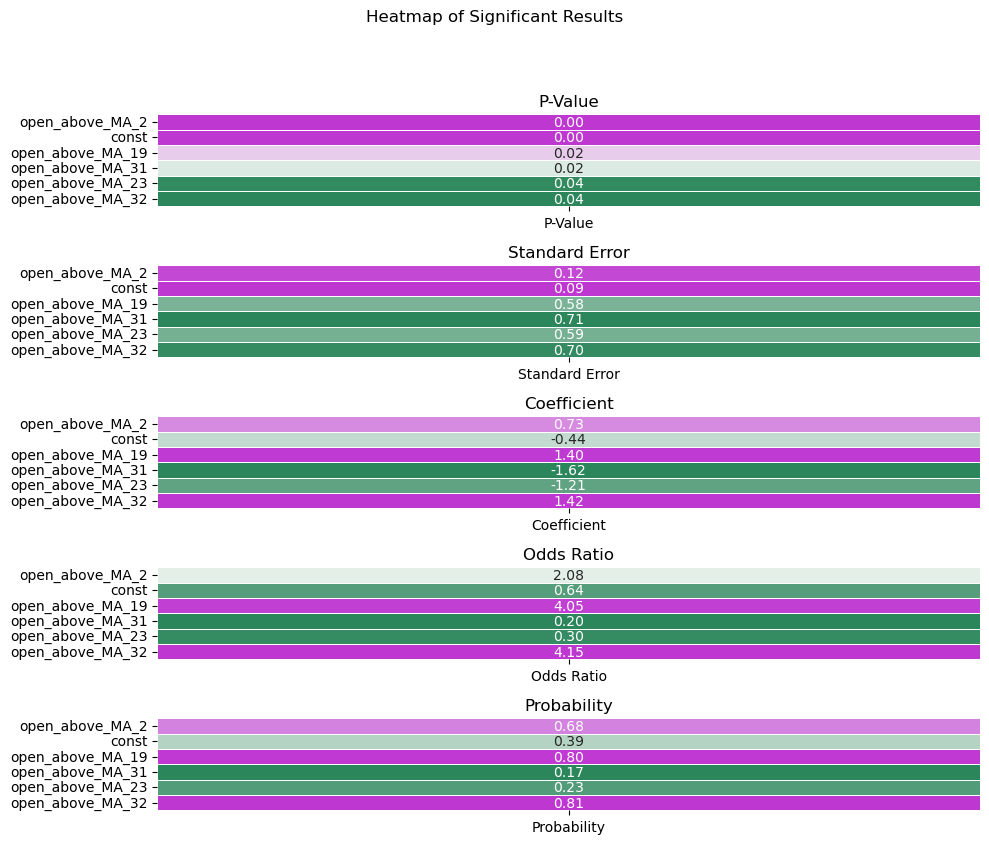

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming `results_summary_sorted_by_pvalue` contains the filtered results

# Prepare the data for the heatmap
heatmap_data = results_summary_sorted_by_pvalue[['P-Value', 'Standard Error', 'Coefficient', 'Odds Ratio', 'Probability']]

# Normalize each column based on the desired "good" values
normalized_data = heatmap_data.copy()
normalized_data['P-Value'] = (heatmap_data['P-Value'] - heatmap_data['P-Value'].min()) / (heatmap_data['P-Value'].max() - heatmap_data['P-Value'].min())
normalized_data['Standard Error'] = (heatmap_data['Standard Error'] - heatmap_data['Standard Error'].min()) / (heatmap_data['Standard Error'].max() - heatmap_data['Standard Error'].min())
normalized_data['Coefficient'] = (heatmap_data['Coefficient'] - heatmap_data['Coefficient'].min()) / (heatmap_data['Coefficient'].max() - heatmap_data['Coefficient'].min())
normalized_data['Odds Ratio'] = (heatmap_data['Odds Ratio'] - heatmap_data['Odds Ratio'].min()) / (heatmap_data['Odds Ratio'].max() - heatmap_data['Odds Ratio'].min())
normalized_data['Probability'] = (heatmap_data['Probability'] - heatmap_data['Probability'].min()) / (heatmap_data['Probability'].max() - heatmap_data['Probability'].min())

# Define custom colormaps
cmap_good = sns.diverging_palette(145, 300, s=85, l=50, as_cmap=True)
cmap_bad = sns.diverging_palette(300, 145, s=85, l=50, as_cmap=True)

# Create a custom function to apply color based on the column
def get_colormap(col):
    if col in ['P-Value', 'Standard Error']:
        return cmap_bad
    else:
        return cmap_good

# Create the heatmap
plt.figure(figsize=(10, 8))
for i, col in enumerate(heatmap_data.columns):
    ax = plt.subplot(heatmap_data.shape[1], 1, i + 1)
    sns.heatmap(pd.DataFrame(normalized_data[col]), annot=heatmap_data[[col]], cmap=get_colormap(col), cbar=False, ax=ax, fmt=".2f", linewidths=0.5)
    plt.title(col)
    
# Set titles and labels
plt.suptitle('Heatmap of Significant Results', y=1.05)
plt.tight_layout()

# Show the heatmap
plt.show()


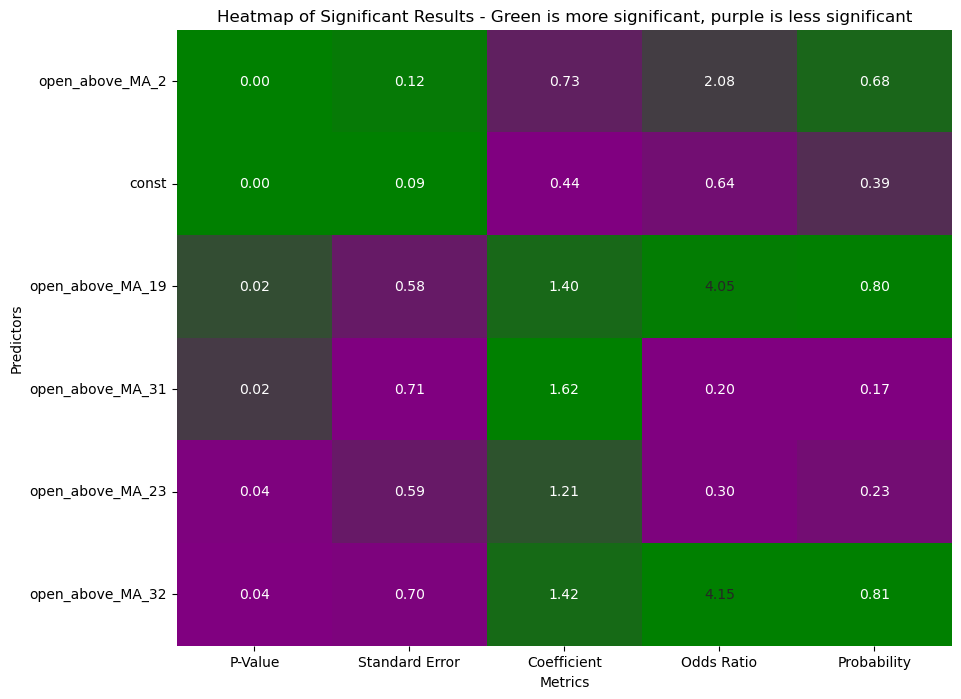

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming `results_summary_sorted_by_pvalue` contains the filtered results

# Prepare the data for the heatmap
heatmap_data = results_summary_sorted_by_pvalue[['P-Value', 'Standard Error', 'Coefficient', 'Odds Ratio', 'Probability']]

# Take the absolute values
heatmap_data = heatmap_data.abs()

# Normalize each column based on the desired "good" values
normalized_data = heatmap_data.copy()
normalized_data['P-Value'] = (heatmap_data['P-Value'] - heatmap_data['P-Value'].min()) / (heatmap_data['P-Value'].max() - heatmap_data['P-Value'].min())
normalized_data['Standard Error'] = (heatmap_data['Standard Error'] - heatmap_data['Standard Error'].min()) / (heatmap_data['Standard Error'].max() - heatmap_data['Standard Error'].min())
normalized_data['Coefficient'] = (heatmap_data['Coefficient'] - heatmap_data['Coefficient'].min()) / (heatmap_data['Coefficient'].max() - heatmap_data['Coefficient'].min())
normalized_data['Odds Ratio'] = (heatmap_data['Odds Ratio'] - heatmap_data['Odds Ratio'].min()) / (heatmap_data['Odds Ratio'].max() - heatmap_data['Odds Ratio'].min())
normalized_data['Probability'] = (heatmap_data['Probability'] - heatmap_data['Probability'].min()) / (heatmap_data['Probability'].max() - heatmap_data['Probability'].min())

# Define custom color maps
cmap_good = LinearSegmentedColormap.from_list('green_to_purple', ['purple', 'green'])
cmap_bad = LinearSegmentedColormap.from_list('purple_to_green', ['green', 'purple'])

# Create a custom function to apply color based on the column
def apply_colormap(value, col):
    if col in ['P-Value', 'Standard Error']:
        return cmap_bad(value)
    else:
        return cmap_good(value)

# Create a matrix of colors for the heatmap
colors = normalized_data.copy()
for col in heatmap_data.columns:
    colors[col] = normalized_data[col].apply(apply_colormap, col=col)

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cbar=False)

# Apply the colors to the heatmap
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor='none', facecolor=colors.iloc[i, j]))

# Set titles and labels
plt.title('Heatmap of Significant Results - Green is more significant, purple is less significant')
plt.xlabel('Metrics')
plt.ylabel('Predictors')

# Show the heatmap
plt.show()

print('''
the more green the more it contributes to decision-usefulness. The more purple, the less so. The most-purple box is the most 
important for any given feature.
''')


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Sat, 04 Jan 2025   Prob (F-statistic):              0.947
Time:                        16:57:03   Log-Likelihood:                 7578.4
No. Observations:                2467   AIC:                        -1.515e+04
Df Residuals:                    2465   BIC:                        -1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

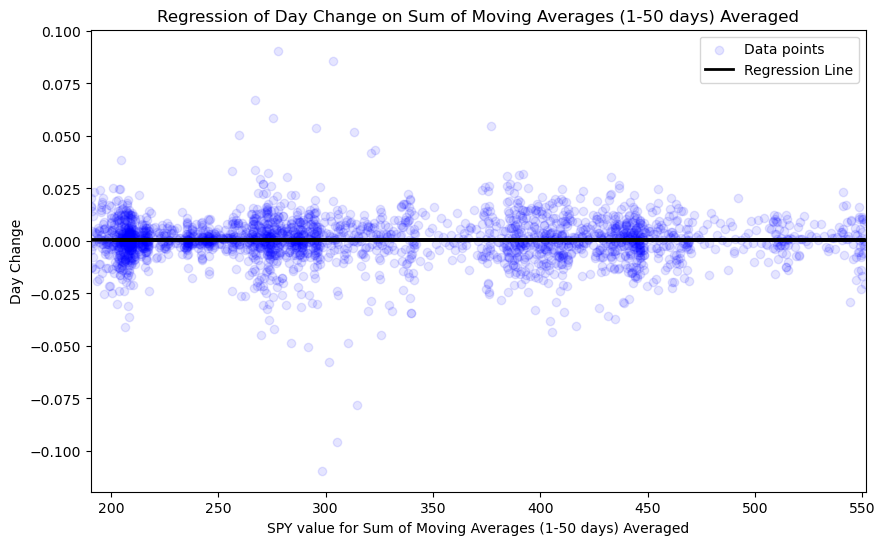



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




In [16]:
#### Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('SPY value for Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')
